<a href="https://colab.research.google.com/github/trekkateer/jcn6-CS-375/blob/main/notebooks/4A-Linear-Regression-the-Hard-Way.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multiple Linear Regression, the Hard Way

### Goals

- Extend our understanding of the linear regression model to multiple features

We're going to do the house-price-prediction example, but doing the linear regression part by hand, like we did last week with the single-feature case.

## Setup

Let's import necessary modules: *pandas* and NumPy for data wrangling, Matplotlib for plotting, and some sklearn utilities. We'll be implementing the linear regression model ourselves, so we don't need to import it from sklearn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.optimize

# This utility function (inspired by https://github.com/HIPS/autograd/blob/master/autograd/misc/flatten.py)
# is useful for optimizing using scipy.optimize.minimize.
def flatten(arrs):
    """Return a 1D array containing the elements of the input arrays,
    and an unflatten function that takes a flattened array and returns
    the original arrays.
    """
    arrs = [np.asarray(arr) for arr in arrs]
    shapes = [arr.shape for arr in arrs]
    flat = np.concatenate([arr.ravel() for arr in arrs])
    start_indices = np.cumsum([0] + [arr.size for arr in arrs])
    def unflatten(params):
        return [params[start_indices[i]:start_indices[i+1]].reshape(shape)
                for i, shape in enumerate(shapes)]
    return flat, unflatten


We'll load the data as before.

In [2]:
ames = pd.read_csv('https://github.com/kcarnold/AmesHousing/blob/master/data/ames.csv.gz?raw=true', compression="gzip")
ames['price'] = ames["Sale_Price"] / 100_000 # Make `price` be in units of $100k, to be easier to interpret.


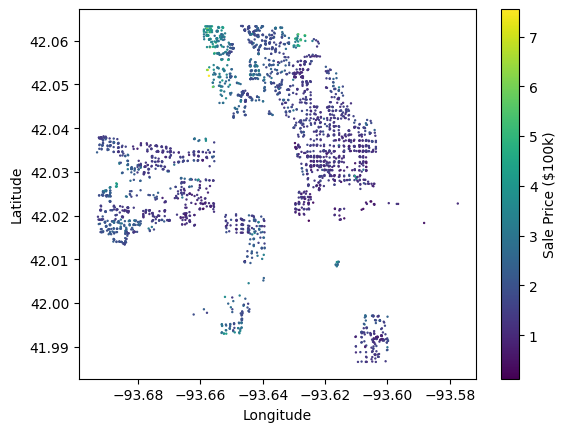

In [3]:
def plot_data():
    # You don't have to know how this function works.
    plt.scatter(ames['Longitude'], ames['Latitude'], c=ames["price"], s=.5)
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.colorbar(label="Sale Price ($100k)")
plot_data()

In [4]:
feature_names = ['Longitude', 'Latitude']
X = ames[feature_names].values
X.shape

(2930, 2)

Our target, called `y` by convention, will be the home price (we'll soon introduce a different *y*, but start with this one).

In [5]:
y = ames['price'].values
y.shape

(2930,)

Notice that `X` has two axes and thus is written in uppercase; `y` has 1 and thus is written in lowercase. (This is `sklearn` convention; other libraries are less consistent about this.)

Now let's split the data into a `train` and `valid` set (which sklearn calls train-*test*, but that's fine). `random_state` is how `sklearn` specifies the random seed (it's actually slightly more flexible than a seed).

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42)

We'll verify that the shapes make sense. Note how many items are in each of the sets.

In [7]:
X_train.shape, y_train.shape

((2344, 2), (2344,))

In [8]:
X_valid.shape, y_valid.shape

((586, 2), (586,))

Here's a function to plot our regression model in "data space" (i.e., what it would predict everywhere on the map).

This function is pretty customized to our specific use case, though you can get inspiration from it for use in other situations.

In [9]:
def plot_model(prediction_fn, fig=None, prediction_args=()):
    # Compute extents
    lat_min = ames.Latitude.min()
    lat_max = ames.Latitude.max()
    lon_min = ames.Longitude.min()
    lon_max = ames.Longitude.max()
    price_min = ames.price.min()
    price_max = ames.price.max()

    # Ask the classifier for predictions on a grid
    xx, yy = np.meshgrid(np.linspace(lon_min, lon_max, 250), np.linspace(lat_min, lat_max, 250))
    Z = prediction_fn(np.c_[xx.ravel(), yy.ravel()], *prediction_args).reshape(xx.shape)

    if fig is None:
        fig = plt.figure(figsize=plt.figaspect(2))

    # Left side: show the predictions in 2D. Superimpose the original data.
    ax = fig.add_subplot(2, 1, 1)
    surf = ax.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.viridis, vmin=price_min, vmax=price_max)
    ax.scatter(ames['Longitude'], ames['Latitude'], c=ames["price"], s=1, cmap='viridis', vmin=price_min, vmax=price_max)
    ax.set(xlabel="Longitude", ylabel="Latitude", title="2D contour view")
    fig.colorbar(surf, label="Sale Price ($100k)")

    # Right side: show the predictions in 3D
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    ax.plot_surface(xx, yy, Z, alpha=.5, cmap=plt.cm.viridis, vmin=price_min, vmax=price_max)
    #ax.scatter(ames['Longitude'], ames['Latitude'], c=ames["price"], s=1, cmap='viridis', vmin=price_min, vmax=price_max)
    ax.set(title="3D view")

## Task

### Part A: Linear regression

Step A1: **Fit a linear regression model to the training set (`X_train`, `y_train`).**

Last time you did this, you used `sklearn`. This time, you'll do it by hand. You'll need to calculate the coefficients `w` and `b` that minimize the mean squared error (MSE) between the model's predictions and the actual values.

I'll walk you through this. First, we'll work on making a single prediction. To do that, we'll need some `weights` and a `bias`, which we'll initialize randomly. **Think about what shape these should be.**

In [20]:
np.random.seed(42)

weights = np.random.standard_normal(size=2)
bias = np.random.standard_normal()
weights, bias

(array([ 0.49671415, -0.1382643 ]), 0.6476885381006925)

Now we'll make a single prediction. Think about how you can do this using a dot product.

In [22]:
x_i = X_train[0] # example data point
y_pred_i = (X @ weights + bias)[0]
y_pred_i #np.float64(-51.67595519554893)

np.float64(-51.66914003583281)

Next we'll make a prediction for every item in the training set. Think about how you can do this using a dot product.

In [23]:
def linreg_forward(X, weights, bias):
    return X @ weights + bias

y_pred_train = linreg_forward(X_train, weights, bias)
y_pred_train.shape

(2344,)

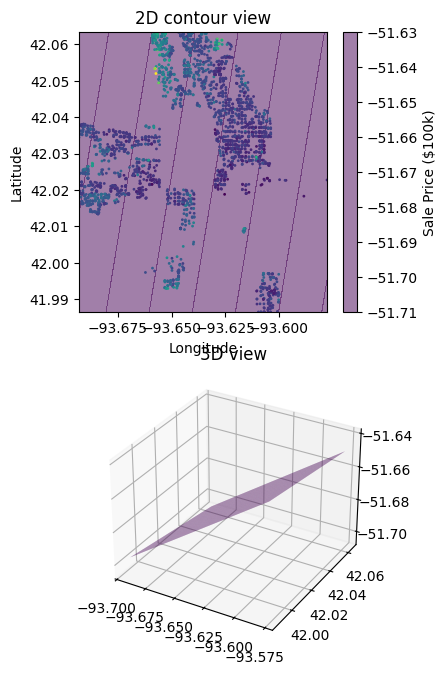

In [ ]:
plot_model(linreg_forward, prediction_args=(weights, bias))

Now let's compute the loss and optimize it, as before.

In [30]:
def compute_mse_loss(y_true, y_pred):
    return abs(np.mean(y_pred ** 2) - np.mean(y_true ** 2))

mse_loss = compute_mse_loss(y_valid, y_pred_train)
print("MSE loss:", mse_loss) # 2858.9442548850384

MSE loss: 2666.181633062326


We'll pack the parameters into a single vector, and then we'll use the `minimize` function from `scipy.optimize` to find the best parameters.

In [31]:
def loss_given_params(params, X, y_true):
    weights, bias = unpack_params(params)
    y_pred = X @ weights + bias
    return compute_mse_loss(y_true, y_pred)

initial_params, unpack_params = flatten([weights, bias])
loss = loss_given_params(initial_params, X_train, y_train)
print("loss:", loss) # should be the same as mse_loss above

loss: 2666.7964214245253


In [32]:
optimization_result = scipy.optimize.minimize(loss_given_params, initial_params, args=(X_train, y_train))
fitted_params = optimization_result.x
weights, bias = unpack_params(fitted_params)
print("Fitted weights:", weights)
print("Fitted bias:", bias)

Fitted weights: [0.09667635 0.19979396]
Fitted bias: 0.6539766837858366


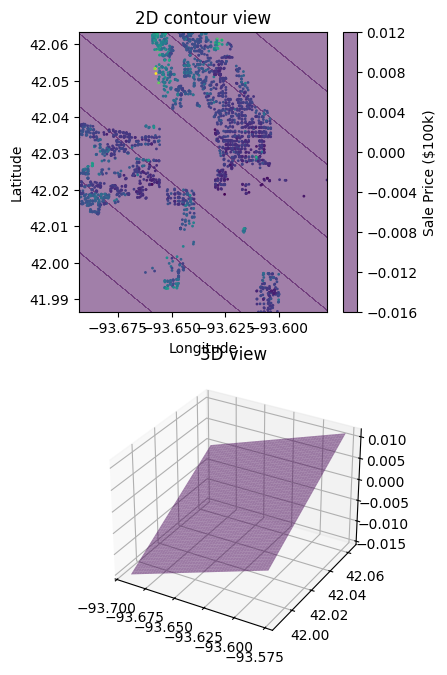

In [33]:
weights, bias = unpack_params(fitted_params)
plot_model(linreg_forward, prediction_args=(weights, bias))

## Analysis

1. What are the shapes of `X`, `y`, `w`, and `b`? Explain why each has the shape it does.

2. Suppose we were trying to predict the original, un-scaled sale price. (i.e., all of our predictions need to be multiplied by 100,000.) Could you adjust the model that we just trained to do that *without* needing to call `minimize` again? If so, how? If not, why not?

*__1.__ X has a shape of (2930, 2): that is, 2930 touples with the values of longitude and latitude.<br/>
y has a shape of (2930,): 2930 prices corresponding to the location values in X.<br/>
w has a shape of (2,), representing the weights that are cross-multiplied with X to produce an optimal prediction of y. It needs to be two values because this is the only way that the cross-multiplication can work.<br/>
b has a shape of (1,) and represents bias. It needs to be a simple float so that it can be added to the result of X @ w.*

*__2.__ Yes, simply divide the training data (y_train) by 100,000, and this will predict the price of the house in hundreds of thousands of dollars.*